In [1]:
import numpy as np
import bms_env_new
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
import random




from utils import *


# Import the necessary libraries
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.env_checker import check_env

In [2]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.linear_model import LinearRegression
# from sklearn.preprocessing import PolynomialFeatures

# # Data from the image
# data = np.array([
#     [0.9, 0.1063, 0.0303, 726.32, 0.0099, 636.78],
#     [0.8, 0.1016, 0.0302, 734.10, 0.0102, 594.41],
#     [0.7, 0.1020, 0.0315, 766.53, 0.0105, 575.44],
#     [0.6, 0.1023, 0.0390, 929.76, 0.0078, 613.48],
#     [0.5, 0.1024, 0.0271, 1131.40, 0.0078, 789.73],
#     [0.4, 0.1040, 0.0275, 1161.67, 0.0077, 791.77],
#     [0.3, 0.1042, 0.0272, 1128.74, 0.0077, 788.39],
#     [0.2, 0.1070, 0.0272, 982.50, 0.0076, 746.24],
#     [0.1, 0.1325, 0.0498, 747.54, 0.0096, 639.61]
# ])

# # Splitting the data
# X = data[:, 0].reshape(-1, 1)  # SoC values
# Y = data[:, 1:]  # Remaining columns

# # Transform input data to include quadratic terms
# poly = PolynomialFeatures(degree= 4)
# X_poly = poly.fit_transform(X)

# # Train a model for each output
# models = []
# for i in range(Y.shape[1]):
#     model = LinearRegression()
#     model.fit(X_poly, Y[:, i])
#     models.append(model)

# # Generate a range of SoC values for prediction
# X_plot = np.linspace(0.1, 0.9, 100).reshape(-1, 1)
# X_plot_poly = poly.transform(X_plot)

# # Plotting
# fig, axs = plt.subplots(5, 1, figsize=(10, 20))
# output_labels = ['R0 (Ω)', 'R1 (Ω)', 'C1 (F)', 'R2 (Ω)', 'C2 (F)']

# for i, ax in enumerate(axs):
#     predictions = models[i].predict(X_plot_poly)
#     ax.scatter(X, Y[:, i], color='red', label='Data Points')
#     ax.plot(X_plot, predictions, label='Fit')
#     ax.set_title(f'Model for {output_labels[i]}')
#     ax.set_xlabel('State of Charge (SoC)')
#     ax.set_ylabel(output_labels[i])
#     ax.legend()

# plt.tight_layout()
# plt.show()

In [3]:
num_cells = 5
bms = bms_env_new.BMSenv(num_cells= num_cells, k_tanh_params= np.random.uniform(0, 0.12, num_cells),
                          Q_cells =np.random.uniform(3., 4. ,num_cells))




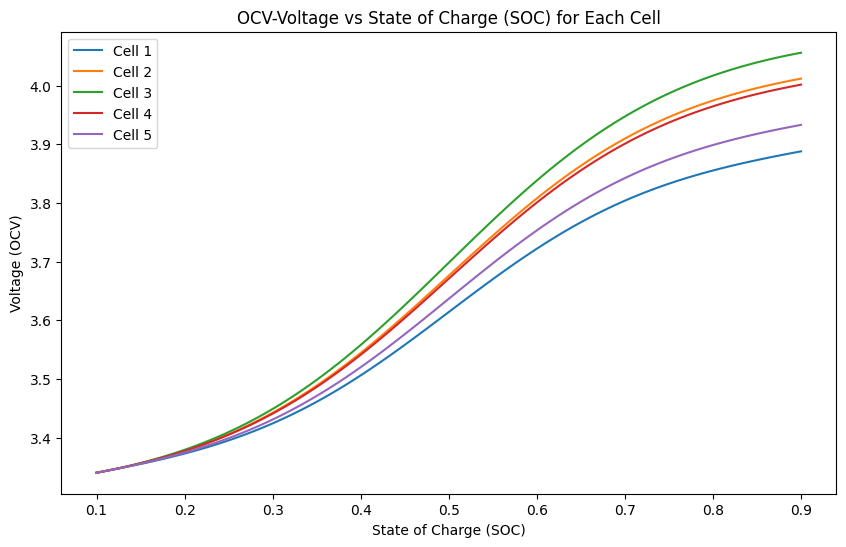

In [4]:
plot_voltage_vs_soc(bms)

In [5]:
T = 20_000

# Always disconected (All the batteries stay still)

In [6]:
bms.reset(seed = 0)
states_soc_1 = [bms.state[:num_cells]]
states_voltage_1 = [bms.state[num_cells:]]
actions_1 = []
rewards_1 = []
dones_1 = [False]

while not dones_1[-1] and len(states_soc_1) < T:
    action = [0 for _ in range(num_cells)]
   
    
    actions_1.append(action)
    state, reward, done, _, _ = bms.step(action)
    states_soc_1.append(state[:num_cells])
    states_voltage_1.append(state[num_cells:])
    rewards_1.append(reward)
    dones_1.append(done)

print(f"Sum of rewards: {np.sum(rewards_1)}")

charge_end_1 = len(states_soc_1)
mean_capacity_1 = np.mean(states_soc_1[-1])
min_capacity_1 = np.min(states_soc_1[-1])
actions_1 = np.array(actions_1)
mismatches_1 = sum([np.sum(actions_1[i] != actions_1[i+1]) for i in range(len(actions_1) - 1)])




while states_soc_1[-1].min() > 0.1:
    bms.discharge()
    states_soc_1.append(bms.state[:num_cells])
    states_voltage_1.append(bms.state[num_cells:])

print(f"Length of charge: {charge_end_1}")
print(f"Length of discharge: {len(states_soc_1) - charge_end_1}")
print(f"Total length: {len(states_soc_1)}")
print(f"Mean capacity: {np.round(mean_capacity_1, 3)}")
print(f"Min capacity: {np.round(min_capacity_1, 3)}")
print(f"Number of mismatches: {mismatches_1}")


Sum of rewards: -118.98557360134784
Length of charge: 108
Length of discharge: 124
Total length: 232
Mean capacity: 0.84
Min capacity: 0.746
Number of mismatches: 0


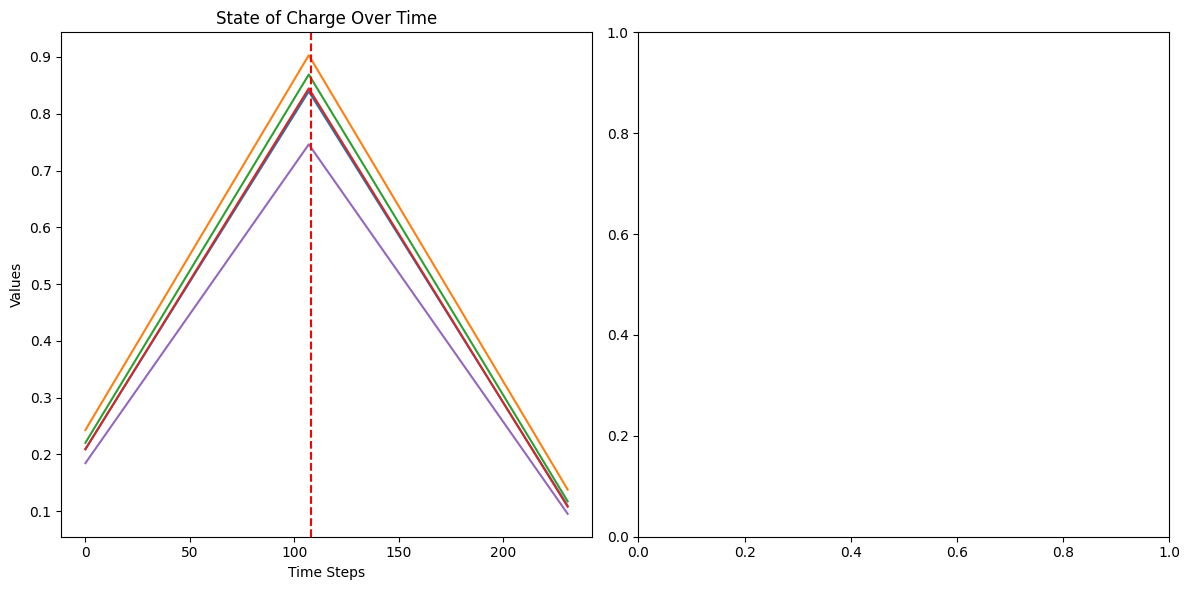

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Plot for State of Charge
axs[0].plot(states_soc_1, label='State of Charge')
axs[0].set_title('State of Charge Over Time')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Values')
axs[0].axvline(x=charge_end_1, color='r', linestyle='--', label='Charge End')

# # Plot for Voltage
# axs[1].plot(states_voltage_1, label='Voltage')
# axs[1].set_title('Voltage Over Time')
# axs[1].set_xlabel('Time Steps')
# axs[1].set_ylabel('Values')
# axs[1].axvline(x=charge_end_1, color='r', linestyle='--', label='Charge End')


plt.tight_layout()  # Adjust layout to prevent overlap


# Always connected (All the batteries Discharge)

In [8]:
bms.reset(seed = 0)
states_soc_2 = [bms.state[:num_cells]]
states_voltage_2 = [bms.state[num_cells:]]
actions_2 = []
rewards_2 = []
dones_2 = [False]

while not dones_2[-1] and len(states_soc_2) < T:
    action = [1 for _ in range(num_cells)]
    actions_2.append(action)
    state, reward, done, _, _ = bms.step(action)
    states_soc_2.append(state[:num_cells])
    states_voltage_2.append(state[num_cells:])
    rewards_2.append(reward)
    dones_2.append(done)

print(f"Sum of rewards: {np.sum(rewards_2)}")

charge_end_2 = len(states_soc_2)
mean_capacity_2 = np.mean(states_soc_2[-1])
min_capacity_2 = np.min(states_soc_2[-1])
actions_2 = np.array(actions_2)
mismatches_2 = sum([np.sum(actions_2[i] != actions_2[i+1]) for i in range(len(actions_2) - 1)])


while states_soc_2[-1].min() > 0.1:
    bms.discharge()
    states_soc_2.append(bms.state[:num_cells])
    states_voltage_2.append(bms.state[num_cells:])

print(f"Length of charge: {charge_end_2}")
print(f"Length of discharge: {len(states_soc_2) - charge_end_2}")
print(f"Total length: {len(states_soc_2)}")
print(f"Mean capacity: {np.round(mean_capacity_2, 3)}")
print(f"Min capacity: {np.round(min_capacity_2, 3)}")
print(f"Number of mismatches: {mismatches_2}")



Sum of rewards: -252.38293803424511
Length of charge: 254
Length of discharge: 127
Total length: 381
Mean capacity: 0.85
Min capacity: 0.769
Number of mismatches: 0


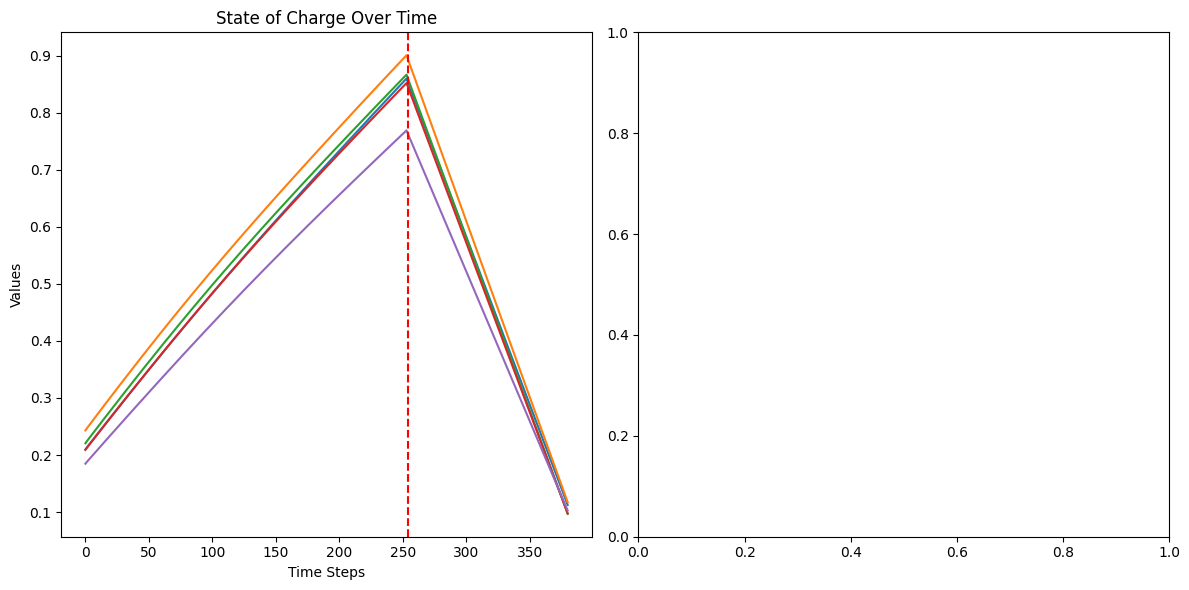

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Plot for State of Charge
axs[0].plot(states_soc_2, label='State of Charge')
axs[0].set_title('State of Charge Over Time')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Values')
axs[0].axvline(x=charge_end_2, color='r', linestyle='--', label='Charge End')

# # Plot for Voltage
# axs[1].plot(states_voltage_2, label='Voltage')
# axs[1].set_title('Voltage Over Time')
# axs[1].set_xlabel('Time Steps')
# axs[1].set_ylabel('Values')
# axs[1].axvline(x=charge_end_2, color='r', linestyle='--', label='Charge End')

plt.tight_layout()  # Adjust layout to prevent overlap
#

# Random Controller

In [10]:
bms.reset(seed = 0)
states_soc_3 = [bms.state[:num_cells]]
states_voltage_3 = [bms.state[num_cells:]]
actions_3 = []
rewards_3 = []
dones_3 = [False]

while not dones_3[-1] and len(states_soc_3) < T:
    action = [np.random.randint(0, 2) for _ in range(num_cells)]
    # print('action', action)
    # print('\n')
    actions_3.append(action)
    state, reward, done, _, _ = bms.step(action)
    states_soc_3.append(state[:num_cells])
    states_voltage_3.append(state[num_cells:])
    rewards_3.append(reward)
    dones_3.append(done)

print(f"Sum of rewards: {np.sum(rewards_3)}")

charge_end_3 = len(states_soc_3)
mean_capacity_3 = np.mean(states_soc_3[-1])
min_capacity_3 = np.min(states_soc_3[-1])
actions_3 = np.array(actions_3)
mismatches_3 = sum([np.sum(actions_3[i] != actions_3[i+1]) for i in range(len(actions_3) - 1)])




while states_soc_3[-1].min() > 0.1:
    bms.discharge()
    states_soc_3.append(bms.state[:num_cells])
    states_voltage_3.append(bms.state[num_cells:])

print(f"Length of charge: {charge_end_3}")
print(f"Length of discharge: {len(states_soc_3) - charge_end_3}")
print(f"Total length: {len(states_soc_3)}")
print(f"Mean capacity: {np.round(mean_capacity_3, 3)}")
print(f"Min capacity: {np.round(min_capacity_3, 3)}")
print(f"Number of mismatches: {mismatches_3}")



Sum of rewards: -125.7668147896623
Length of charge: 157
Length of discharge: 127
Total length: 284
Mean capacity: 0.859
Min capacity: 0.807
Number of mismatches: 376


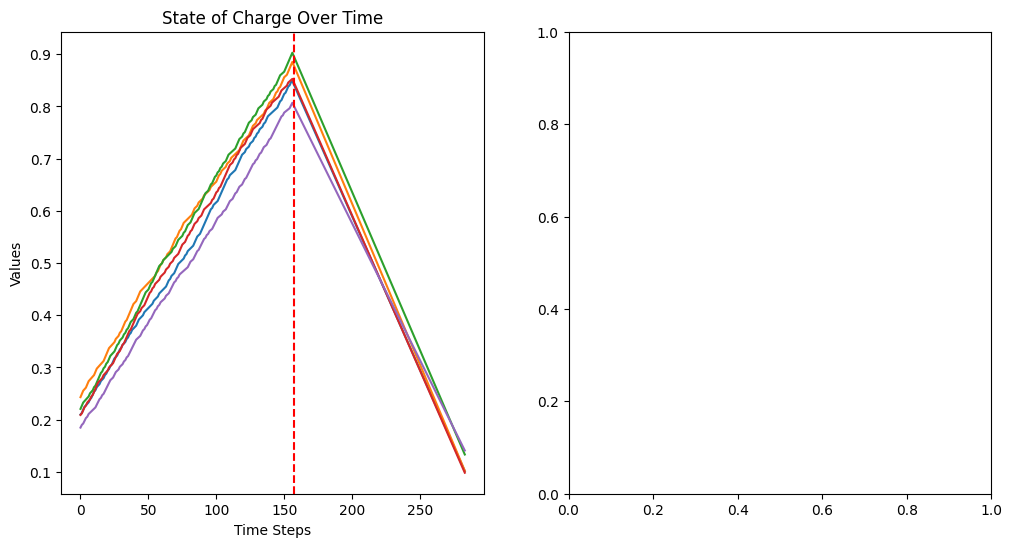

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Plot for State of Charge
axs[0].plot(states_soc_3, label='State of Charge')
axs[0].set_title('State of Charge Over Time')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Values')
axs[0].axvline(x=charge_end_3, color='r', linestyle='--', label='Charge End')

# # Plot for Voltage
# axs[1].plot(states_voltage_3, label='Voltage')
# axs[1].set_title('Voltage Over Time')
# axs[1].set_xlabel('Time Steps')
# axs[1].set_ylabel('Values')
# axs[1].axvline(x=charge_end_3, color='r', linestyle='--', label='Charge End')

# plt.tight_layout()  # Adjust layout to prevent overlap


# Rule-Based


In [12]:
bms.reset(seed = 0)
states_soc_4 = [bms.state[:num_cells]]
states_voltage_4 = [bms.state[num_cells:]]
actions_4 = []
rewards_4 = []
dones_4 = [False]

while not dones_4[-1] and len(states_soc_4) < T:
    median_soc = np.median(states_soc_4[-1])
    action = [1 if soc > (states_soc_4[-1].min() + 0.05) else 0 for soc in states_soc_4[-1]]
    actions_4.append(action)
    state, reward, done, _, _ = bms.step(action)
    states_soc_4.append(state[:num_cells])
    states_voltage_4.append(state[num_cells:])
    rewards_4.append(reward)
    dones_4.append(done)

print(f"Sum of rewards: {np.sum(rewards_4)}")

charge_end_4 = len(states_soc_4)
mean_capacity_4 = np.mean(states_soc_4[-1])
min_capacity_4 = np.min(states_soc_4[-1])
actions_4 = np.array(actions_4)
mismatches_4 = sum([np.sum(actions_4[i] != actions_4[i+1]) for i in range(len(actions_4) - 1)])




while states_soc_4[-1].min() > 0.1:
    bms.discharge()
    states_soc_4.append(bms.state[:num_cells])
    states_voltage_4.append(bms.state[num_cells:])

print(f"Length of charge: {charge_end_4}")
print(f"Length of discharge: {len(states_soc_4) - charge_end_4}")
print(f"Total length: {len(states_soc_4)}")
print(f"Mean capacity: {np.round(mean_capacity_4, 3)}")
print(f"Min capacity: {np.round(min_capacity_4, 3)}")
print(f"Number of mismatches: {mismatches_4}")


Sum of rewards: -63.958213909109915
Length of charge: 128
Length of discharge: 130
Total length: 258
Mean capacity: 0.89
Min capacity: 0.851
Number of mismatches: 186


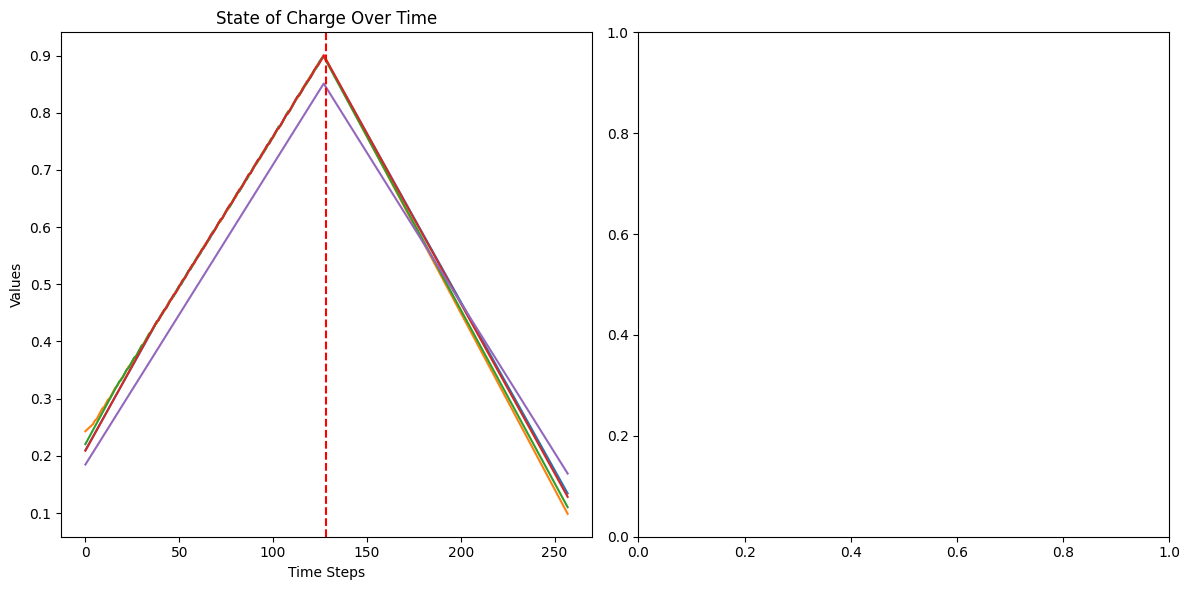

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Plot for State of Charge
axs[0].plot(states_soc_4, label='State of Charge')
axs[0].set_title('State of Charge Over Time')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Values')
axs[0].axvline(x=charge_end_4, color='r', linestyle='--', label='Charge End')

# # Plot for Voltage
# axs[1].plot(states_voltage_4, label='Voltage')
# axs[1].set_title('Voltage Over Time')
# axs[1].set_xlabel('Time Steps')
# axs[1].set_ylabel('Values')
# axs[1].axvline(x=charge_end_4, color='r', linestyle='--', label='Charge End')

plt.tight_layout()  # Adjust layout to prevent overlap


# Q Learning (Efficient)

In [14]:
bins = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])


In [15]:
init_Q_value = -0.1
Q = defaultdict(lambda: init_Q_value)

In [16]:
num_episodes = 25

memory_threshold = init_Q_value

for episode in range(num_episodes):

    if episode == num_episodes - 5:
        bms.reset(seed =0)
    else:
        bms.reset()
        
    states_soc_6 = [bms.state[:num_cells]]
    states_voltage_6 = [bms.state[num_cells:]]
    actions_6 = []
    rewards_6 = []
    dones_6 = [False]
    random_actions_6 = []
    actions_int_6 = []
    states_int_6 = [tuple(discretize_features(states_soc_6[-1], bins))]

    epsilon = 0.1
    stepsize = 0.1
    gamma = 0.99

    if episode  >= num_episodes - 10:
        epsilon = 0.0

    while not dones_6[-1] and len(states_soc_6) < T:

        # if len(dones_6) % 1000 == 0:
        #     print('\n')
        #     print(f"Episode: {episode + 1}")
        #     print(f"Timesteps: {len(dones_6)}")
        #     print(f"Memory Threshold:" , memory_threshold)
        #     print(f"Number of unique (state, action) pairs: {len(Q)}")

        state_int = tuple(discretize_features(states_soc_6[-1], bins))

        if np.random.uniform(0, 1) < epsilon:
            random_actions_6.append(True)
            action = bms.action_space.sample()
        else:
            random_actions_6.append(False)
            # Collect all actions with non-zero Q-values for the current state
            state_actions = [(s, a) for (s, a) in Q.keys() if s == state_int]

            if state_actions:
                max_q_value = max(Q[(state_int, a)] for _, a in state_actions)
                max_actions = [a for _, a in state_actions if Q[(state_int, a)] == max_q_value]
                action_int = random.choice(max_actions)
                action = np.array(action_int)
                if max_q_value < init_Q_value:
                    action = bms.action_space.sample()
                    random_actions_6[-1] = True
            else:
                action = bms.action_space.sample()
                random_actions_6[-1] = True

        action_int = tuple(action)
        actions_int_6.append(action_int)

        state, reward, done, _, _ = bms.step(action)
        state_soc = state[:num_cells]
        state_voltage = state[num_cells:]
        states_soc_6.append(state_soc)
        states_voltage_6.append(state_voltage)
        actions_6.append(action)
        rewards_6.append(reward)
        dones_6.append(done)

        if not done:
            next_state_int = tuple(discretize_features(state_soc, bins))
            states_int_6.append(next_state_int)
            next_state_actions = [(s, a) for (s, a) in Q.keys() if np.all(s == next_state_int)]
            if next_state_actions:
                max_next_q_value = max(Q[(next_state_int, a)] for _, a in next_state_actions)
            else:
                max_next_q_value = init_Q_value

            if (state_int, action_int) not in Q:
                Q[(state_int, action_int)] = init_Q_value

            Q[(state_int, action_int)] = Q[(state_int, action_int)] + stepsize * (
                reward + gamma * max_next_q_value - Q[(state_int, action_int)]
            )

        # Remove entries with Q-values less than 0.0
        Q = {k: v for k, v in Q.items() if v >= memory_threshold}
        
        if len(Q) > 1500:
            memory_threshold/=1.1
        if len(Q) < 500 and (np.abs(memory_threshold) < 100):
            memory_threshold*=1.1



    if episode % 1 == 0:
        print('\n\n')
        print(f"Episode: {episode + 1}")
        print(f"Sum of rewards: {np.sum(rewards_6)}")
        print(f"Timesteps: {len(dones_6)}")
        print(f"Number of states visited: {len(set(states_int_6))}")
        print(f"Number of random actions: {sum(random_actions_6)}")
        print(f"Number of unique (state, action) pairs: {len(Q)}")

charge_end_6 = len(states_soc_6)
mean_capacity_6 = np.mean(states_soc_6[-1])
min_capacity_6 = np.min(states_soc_6[-1])
actions_6 = np.array(actions_6)
mismatches_6 = sum([np.sum(actions_6[i] != actions_6[i+1]) for i in range(len(actions_6) - 1)])


while states_soc_6[-1].min() > 0.1:
    bms.discharge()
    states_soc_6.append(bms.state[:num_cells])
    states_voltage_6.append(bms.state[num_cells:])

print(f"\n\n\nLength of charge: {charge_end_6}")
print(f"Length of discharge: {len(states_soc_6) - charge_end_6}")
print(f"Total length: {len(states_soc_6)}")
print(f"Mean capacity: {np.round(mean_capacity_6, 3)}")
print(f"Min capacity: {np.round(min_capacity_6, 3)}")
print(f"Number of mismatches: {mismatches_6}")




Episode: 1
Sum of rewards: -224.65768549962075
Timesteps: 143
Number of states visited: 30
Number of random actions: 142
Number of unique (state, action) pairs: 118



Episode: 2
Sum of rewards: -229.41104698346487
Timesteps: 155
Number of states visited: 30
Number of random actions: 154
Number of unique (state, action) pairs: 251



Episode: 3
Sum of rewards: -242.27899509266993
Timesteps: 157
Number of states visited: 29
Number of random actions: 156
Number of unique (state, action) pairs: 375



Episode: 4
Sum of rewards: -139.43658786341013
Timesteps: 137
Number of states visited: 27
Number of random actions: 136
Number of unique (state, action) pairs: 498



Episode: 5
Sum of rewards: -150.09808698578217
Timesteps: 163
Number of states visited: 27
Number of random actions: 162
Number of unique (state, action) pairs: 630



Episode: 6
Sum of rewards: -253.78869666102625
Timesteps: 147
Number of states visited: 29
Number of random actions: 146
Number of unique (state, action) pai

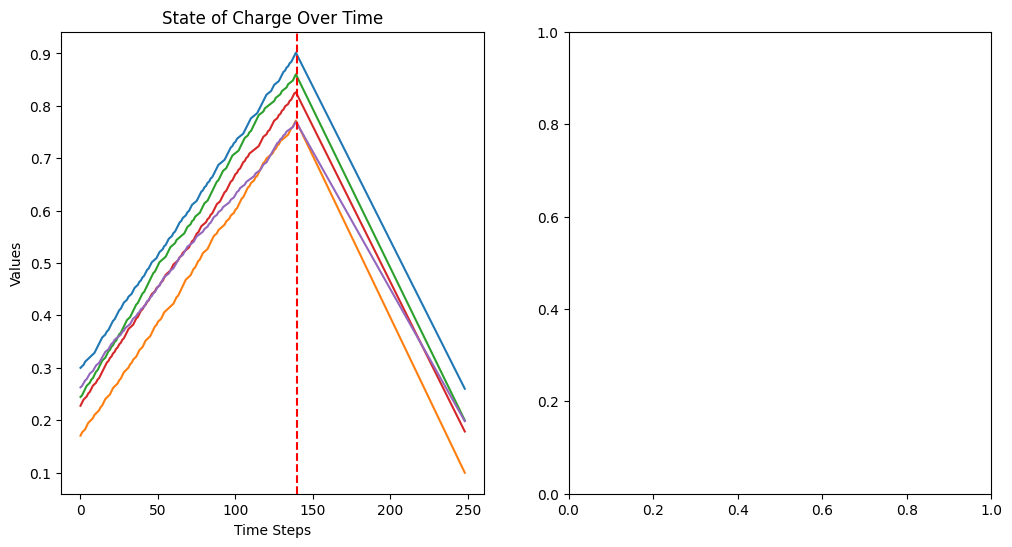

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Plot for State of Charge
axs[0].plot(states_soc_6, label='State of Charge')
axs[0].set_title('State of Charge Over Time')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Values')
axs[0].axvline(x=charge_end_6, color='r', linestyle='--', label='Charge End')

# # Plot for Voltage
# axs[1].plot(states_voltage_6, label='Voltage')
# axs[1].set_title('Voltage Over Time')
# axs[1].set_xlabel('Time Steps')
# axs[1].set_ylabel('Values')
# axs[1].axvline(x=charge_end_6, color='r', linestyle='--', label='Charge End')

# plt.tight_layout()  # Adjust layout to prevent overlap


# PPO

In [18]:
bms.reset()
# Check if the environment follows the gym interface
check_env(bms)

In [19]:
model = PPO("MlpPolicy", bms,  verbose=1)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [20]:
model.save("ppo_bms")

In [38]:
model = PPO.load("ppo_bms", env=bms)
# model.batch_size = int(2**10)
model.learning_rate = 0.0001
model.gamma = 0.99
model.learn(total_timesteps= 200_000)
model.save("ppo_bms")

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 118      |
|    ep_rew_mean     | -142     |
| time/              |          |
|    fps             | 518      |
|    iterations      | 1        |
|    time_elapsed    | 3        |
|    total_timesteps | 2048     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 119         |
|    ep_rew_mean          | -137        |
| time/                   |             |
|    fps                  | 447         |
|    iterations           | 2           |
|    time_elapsed         | 9           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.003993305 |
|    clip_fraction        | 0.0536      |
|    clip_range           | 0.2         |
|    entropy_loss         | -0.976   

In [39]:
model = PPO.load("ppo_bms")

bms.reset(seed = 0)
states_soc_5 = [bms.state[:num_cells]]
states_voltage_5 = [bms.state[num_cells:]]
actions_5 = []
rewards_5 = []
dones_5 = [False]

state = bms.state.copy()
while not dones_5[-1] and len(states_soc_5) < T:
    state_1 = state.copy()


    action, _ = model.predict(state, deterministic= False)
    actions_5.append(action)
    state, reward, done, _, _ = bms.step(action)
    state_2 = state.copy()
    states_soc_5.append(state[:num_cells])
    states_voltage_5.append(state[num_cells:])
    rewards_5.append(reward)
    dones_5.append(done)

print(f"Sum of rewards: {np.sum(rewards_5)}")

charge_end_5 = len(states_soc_5)
mean_capacity_5 = np.mean(states_soc_5[-1])
min_capacity_5 = np.min(states_soc_5[-1])
actions_5 = np.array(actions_5)
mismatches_5 = sum([np.sum(actions_5[i] != actions_5[i+1]) for i in range(len(actions_5) - 1)])



while states_soc_5[-1].min() > 0.1:
    bms.discharge()
    states_soc_5.append(bms.state[:num_cells])
    states_voltage_5.append(bms.state[num_cells:])


print(f"Length of charge: {charge_end_5}")
print(f"Length of discharge: {len(states_soc_5) - charge_end_5}")
print(f"Total length: {len(states_soc_5)}")
print(f"Mean capacity: {np.round(mean_capacity_5, 3)}")
print(f"Min capacity: {np.round(min_capacity_5, 3)}")
print(f"Number of mismatches: {mismatches_5}")



Sum of rewards: -30.313578463664754
Length of charge: 134
Length of discharge: 130
Total length: 264
Mean capacity: 0.896
Min capacity: 0.882
Number of mismatches: 99


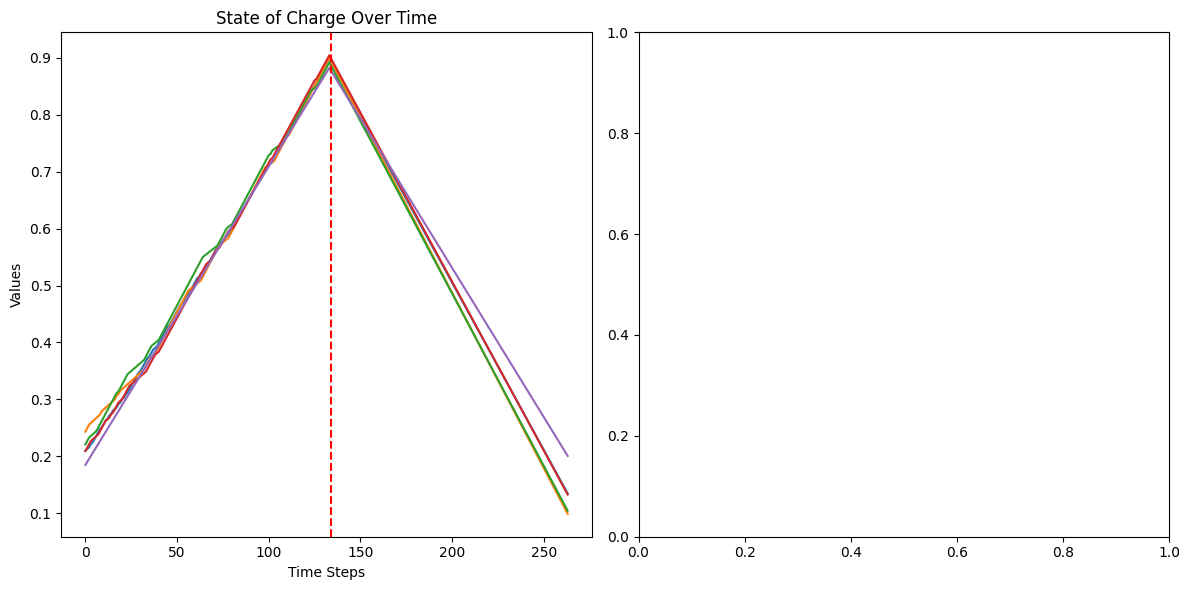

In [40]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))  # Create a figure with 1 row and 2 columns

# Plot for State of Charge
axs[0].plot(states_soc_5, label='State of Charge')
axs[0].set_title('State of Charge Over Time')
axs[0].set_xlabel('Time Steps')
axs[0].set_ylabel('Values')
axs[0].axvline(x=charge_end_5, color='r', linestyle='--', label='Charge End')

# # Plot for Voltage
# axs[1].plot(states_voltage_5, label='Voltage')
# axs[1].set_title('Voltage Over Time')
# axs[1].set_xlabel('Time Steps')
# axs[1].set_ylabel('Values')
# axs[1].axvline(x=charge_end_5, color='r', linestyle='--', label='Charge End')

plt.tight_layout()  # Adjust layout to prevent overlap


In [ ]:
print(f"Length of charge: {charge_end_1}")
print(f"Length of charge: {charge_end_2}")
print(f"Length of charge: {charge_end_3}")
print(f"Length of charge: {charge_end_4}")
print(f"Length of charge: {charge_end_6}")
print(f"Length of charge: {charge_end_5}")


Length of charge: 5
Length of charge: 255
Length of charge: 147
Length of charge: 123
Length of charge: 132
Length of charge: 145


In [ ]:
print(f"Length of discharge: {len(states_soc_1) - charge_end_1}")
print(f"Length of discharge: {len(states_soc_2) - charge_end_2}")
print(f"Length of discharge: {len(states_soc_3) - charge_end_3}")
print(f"Length of discharge: {len(states_soc_4) - charge_end_4}")
print(f"Length of discharge: {len(states_soc_6) - charge_end_6}")
print(f"Length of discharge: {len(states_soc_5) - charge_end_5}")

Length of discharge: 18
Length of discharge: 122
Length of discharge: 120
Length of discharge: 124
Length of discharge: 90
Length of discharge: 95


In [ ]:
print(f"Total length: {len(states_soc_1)}")
print(f"Total length: {len(states_soc_2)}")
print(f"Total length: {len(states_soc_3)}")
print(f"Total length: {len(states_soc_4)}")
print(f"Total length: {len(states_soc_6)}")
print(f"Total length: {len(states_soc_5)}")

Total length: 23
Total length: 377
Total length: 267
Total length: 247
Total length: 222
Total length: 240


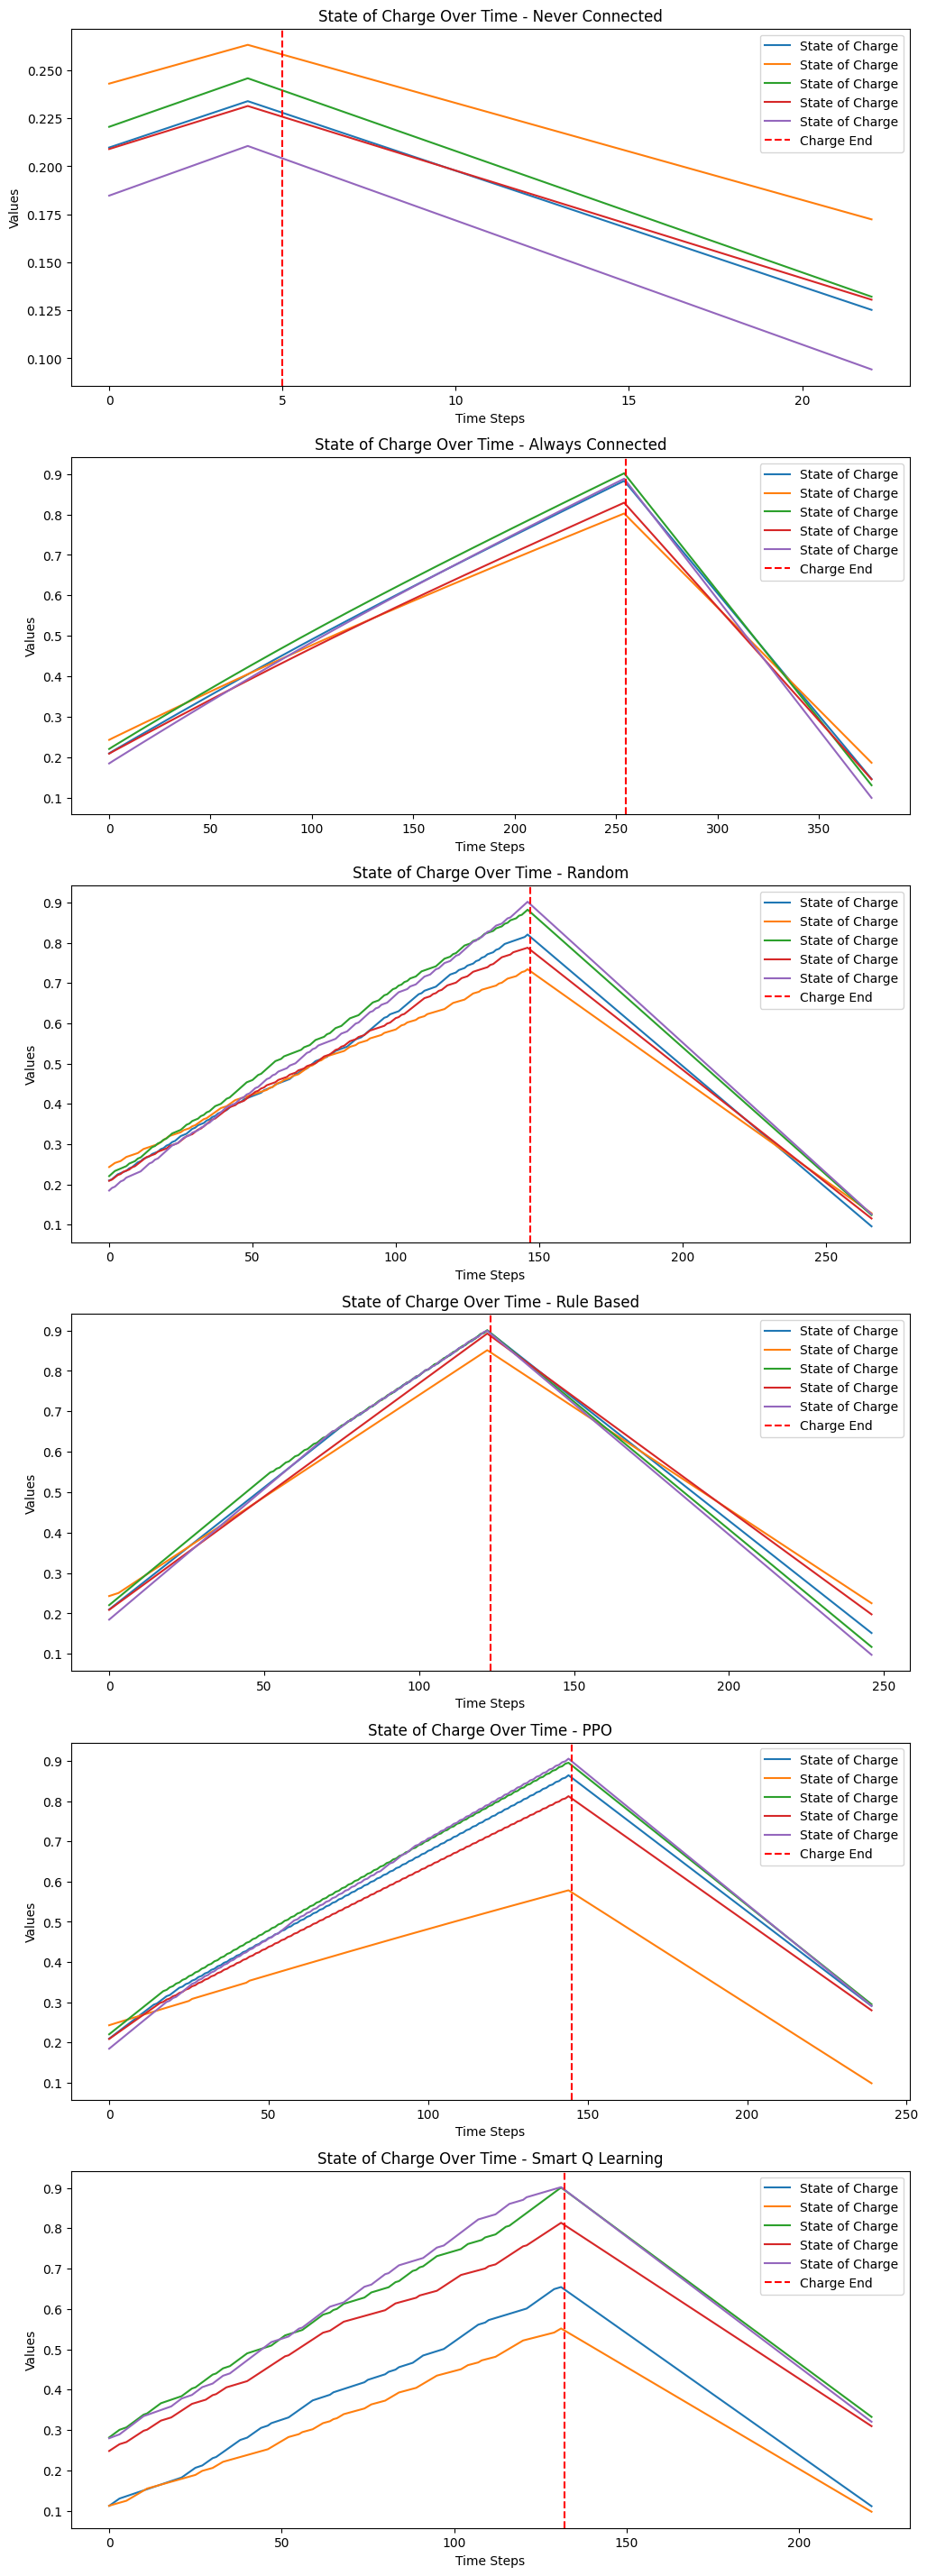

In [ ]:
fig, axs = plt.subplots(6, 1, figsize=(12, 36))  # Create a figure with 6 rows and 1 column

titles = ['Never Connected', 'Always Connected', 'Random', 'Rule Based', 'PPO', 'Smart Q Learning']
states = [states_soc_1, states_soc_2, states_soc_3, states_soc_4, states_soc_5, states_soc_6]
charge_ends = [charge_end_1, charge_end_2, charge_end_3, charge_end_4, charge_end_5, charge_end_6]

for i, ax in enumerate(axs):
    ax.plot(states[i], label='State of Charge')
    ax.set_title(f'State of Charge Over Time - {titles[i]}')
    ax.set_xlabel('Time Steps')
    ax.set_ylabel('Values')
    ax.axvline(x=charge_ends[i], color='r', linestyle='--', label='Charge End')
    ax.legend()

